# Modelling

Prediction models to be developed
- Unit price predictor

In [1]:
from math import sqrt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn import decomposition, linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.model_selection import cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from keys import conn_str

In [2]:
# import data
df = pd.read_sql_table('eda', conn_str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13493 entries, 0 to 13492
Data columns (total 46 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Created                  13493 non-null  datetime64[ns]
 1   index                    13493 non-null  int64         
 2   Number                   13493 non-null  object        
 3   Date                     13493 non-null  object        
 4   Gross                    13493 non-null  float64       
 5   InvoiceID                13493 non-null  object        
 6   PointsEarned             13493 non-null  float64       
 7   Variants.NettPrice       13493 non-null  float64       
 8   Variants.DiscountAmount  13493 non-null  float64       
 9   Variants.Discount        13493 non-null  float64       
 10  Variants.PriceOriginal   13493 non-null  float64       
 11  Variants.Price           13493 non-null  float64       
 12  Variants.Cost            13493 n

In [3]:
df.drop(['Count' ,'Payments.Date', 'PointsEarned', 'Date', 'Variants.Code', 'Payments.Note', 'Payments.Code',
         'Variants.PriceOriginal', 'Gross'], axis=1, inplace=True)

In [4]:
df.isnull().sum()

Created                      0
index                        0
Number                       0
InvoiceID                    0
Variants.NettPrice           0
Variants.DiscountAmount      0
Variants.Discount            0
Variants.Price               0
Variants.Cost                0
Variants.Quantity            0
Variants.Name                0
Payments.Method              0
Payments.Amount              0
year                         0
month                        0
day                          0
dayOfWeek                    0
weekOfMonth                  0
hour                         0
minute                       0
LastPurchaseDate             0
Recency                      0
Frequency                    0
LastPurYear                  0
LastPurMonth                 0
LastPurDay                   0
weekDayOfLastPur             0
yearWeekOfLastPur            0
LastPurHour                  0
LastPurMinute                0
ItemTimeDiff                 1
ProductTimeDiff            260
GrossMar

In [5]:
df = df.rename(columns=
               {"Payments.Amount": "PaidAmount",
                "Payments.Method": "PaymentMethod",
                "Variants.Cost": "UnitCost",
                "Variants.Discount": "ProductDiscount",
                "Variants.DiscountAmount": "ProductDiscountAmount",
                "Variants.Name": "product",
                "Variants.NettPrice": "TotalPrice",
                "Variants.Price": "UnitPrice",
                "Variants.Quantity": "Quantity",
                "day": "Day",
                "hour": "Hour",
                "minute": "Minute",
                "month": "Month",
                "year": "Year",
                "Number": "number",
                "Created": "created",
                "InvoiceID": "invoiceid",
                "dayOfWeek": "DayOfWeek",
                "weekOfMonth": "WeekOfMonth",
                "LastPurchaseDate": "lastPurchaseDate",
                "weekDayOfLastPur": "WeekDayOfLastPur",
                "yearWeekOfLastPur": "WeekOfLastPur"
                })
df.head()

created  index     number  \
0 2020-02-07 22:51:30.473      0  20.02.002   
1 2020-02-07 22:52:50.140      1  20.02.003   
2 2020-02-07 22:53:26.450      2  20.02.004   
3 2020-02-07 23:05:02.100      3  20.02.005   
4 2020-02-07 23:05:02.100      3  20.02.005   

                              invoiceid  TotalPrice  ProductDiscountAmount  \
0  a4f938d7-a234-49f9-9588-ea6dc1b547b2       200.0                    0.0   
1  89681b1f-21ab-4f0a-8780-3971de3f82b0       400.0                    0.0   
2  af594745-e964-4051-ae17-93b23b746743       100.0                    0.0   
3  a76090aa-9470-4ef5-8e38-59568d23bdae       300.0                    0.0   
4  a76090aa-9470-4ef5-8e38-59568d23bdae        80.0                    0.0   

   ProductDiscount  UnitPrice  UnitCost  Quantity  ... WeekOfLastPur  \
0              0.0      200.0       0.0       1.0  ...            22   
1              0.0      200.0     120.0       2.0  ...            45   
2              0.0      100.0      75.0       1.0  ...            38   
3              0.0      300.0     183.0       1.0  ...            46   
4              0.0       80.0       0.0       1.0  ...             8   

  LastPurHour  LastPurMinute  ItemTimeDiff  ProductTimeDiff  GrossMargin  \
0          18             36           1.0           1303.0        200.0   
1          21             13           1.0           2898.0         80.0   
2          20             37          12.0             72.0         25.0   
3          20             26           0.0           2886.0        117.0   
4          18             14          16.0           2725.0         80.0   

   ProfitLoss  MarginPerc  MarginDeviation  DeviationType  
0      Profit    1.000000         0.000000       Negative  
1      Profit    0.666667         0.333333       Negative  
2      Profit    0.333333         0.666667       Negative  
3      Profit    0.639344         0.360656       Negative  
4      Profit    1.000000         0.000000       Negative  

[5 rows x 37 columns]

In [6]:
df = df.reindex(sorted(df.columns), axis=1)
df

Day  DayOfWeek DeviationType  Frequency  GrossMargin  Hour  \
0        7          4      Negative         87        200.0    22   
1        7          4      Negative         14         80.0    22   
2        7          4      Negative        130         25.0    22   
3        7          4      Negative         56        117.0    23   
4        7          4      Negative         11         80.0    23   
...    ...        ...           ...        ...          ...   ...   
13488   25          0      Positive        136         33.0    22   
13489   25          0      Negative         94        -24.0    22   
13490   25          0      Negative         43        -50.0    22   
13491   26          1      Negative         94        -24.0     0   
13492   26          1      Negative         43        -40.0     0   

       ItemTimeDiff  LastPurDay  LastPurHour  LastPurMinute  ...  \
0               1.0          30           18             36  ...   
1               1.0           2           21             13  ...   
2              12.0          20           20             37  ...   
3               0.0          10           20             26  ...   
4              16.0          17           18             14  ...   
...             ...         ...          ...            ...  ...   
13488           0.0          25           22             22  ...   
13489          11.0          26            0              4  ...   
13490          91.0          26            0              4  ...   
13491           0.0          26            0              4  ...   
13492           NaN          26            0              4  ...   

       WeekDayOfLastPur  WeekOfLastPur  WeekOfMonth  Year  \
0                     5             22            6  2020   
1                     0             45            6  2020   
2                     6             38            6  2020   
3                     1             46            6  2020   
4                     0              8            6  2020   
...                 ...            ...          ...   ...   
13488                 0              4            4  2021   
13489                 1              4            4  2021   
13490                 1              4            4  2021   
13491                 1              4            4  2021   
13492                 1              4            4  2021   

                      created  index                             invoiceid  \
0     2020-02-07 22:51:30.473      0  a4f938d7-a234-49f9-9588-ea6dc1b547b2   
1     2020-02-07 22:52:50.140      1  89681b1f-21ab-4f0a-8780-3971de3f82b0   
2     2020-02-07 22:53:26.450      2  af594745-e964-4051-ae17-93b23b746743   
3     2020-02-07 23:05:02.100      3  a76090aa-9470-4ef5-8e38-59568d23bdae   
4     2020-02-07 23:05:02.100      3  a76090aa-9470-4ef5-8e38-59568d23bdae   
...                       ...    ...                                   ...   
13488 2021-01-25 22:22:41.243   2750  746f97a4-947b-497b-830f-dd1d1c05394b   
13489 2021-01-25 22:22:41.243   2750  746f97a4-947b-497b-830f-dd1d1c05394b   
13490 2021-01-25 22:33:50.673   2751  7a2899db-2d87-46bc-a9c4-565d08df0d0d   
13491 2021-01-26 00:04:36.673   2752  5f82a83d-5547-4d20-9b5f-54f1d3b77493   
13492 2021-01-26 00:04:36.673   2752  5f82a83d-5547-4d20-9b5f-54f1d3b77493   

             lastPurchaseDate     number                      product  
0     2020-05-30 18:36:43.857  20.02.002     Ladies Dress 200bob 2001  
1     2020-11-02 21:13:17.210  20.02.003                 Men Trousers  
2     2020-09-20 20:37:31.790  20.02.004                  Men tshirts  
3     2020-11-10 20:26:25.740  20.02.005                Lady Hand bag  
4     2020-02-17 18:14:30.623  20.02.005  Children Jackets 80bob 3003  
...                       ...        ...                          ...  
13488 2021-01-25 22:22:41.243  21.01.513                  Cotton Tops  
13489 2021-01-26 00:04:36.673  21.01.513                     Velvet 4  
13490 2021-01-26 00:04:36.673  21.01.514   

We want to train the model to predict the unit price in a way that will lead to a profit where the margin percentage
will be as close to 1 as possible.

In [7]:
filter_df = df.loc[(df.MarginPerc <= 1) & (df.ProfitLoss == 'Profit')]
filter_df.head()

Day  DayOfWeek DeviationType  Frequency  GrossMargin  Hour  ItemTimeDiff  \
0    7          4      Negative         87        200.0    22           1.0   
1    7          4      Negative         14         80.0    22           1.0   
2    7          4      Negative        130         25.0    22          12.0   
3    7          4      Negative         56        117.0    23           0.0   
4    7          4      Negative         11         80.0    23          16.0   

   LastPurDay  LastPurHour  LastPurMinute  ...  WeekDayOfLastPur  \
0          30           18             36  ...                 5   
1           2           21             13  ...                 0   
2          20           20             37  ...                 6   
3          10           20             26  ...                 1   
4          17           18             14  ...                 0   

   WeekOfLastPur  WeekOfMonth  Year                 created  index  \
0             22            6  2020 2020-02-07 22:51:30.473      0   
1             45            6  2020 2020-02-07 22:52:50.140      1   
2             38            6  2020 2020-02-07 22:53:26.450      2   
3             46            6  2020 2020-02-07 23:05:02.100      3   
4              8            6  2020 2020-02-07 23:05:02.100      3   

                              invoiceid        lastPurchaseDate     number  \
0  a4f938d7-a234-49f9-9588-ea6dc1b547b2 2020-05-30 18:36:43.857  20.02.002   
1  89681b1f-21ab-4f0a-8780-3971de3f82b0 2020-11-02 21:13:17.210  20.02.003   
2  af594745-e964-4051-ae17-93b23b746743 2020-09-20 20:37:31.790  20.02.004   
3  a76090aa-9470-4ef5-8e38-59568d23bdae 2020-11-10 20:26:25.740  20.02.005   
4  a76090aa-9470-4ef5-8e38-59568d23bdae 2020-02-17 18:14:30.623  20.02.005   

                       product  
0     Ladies Dress 200bob 2001  
1                 Men Trousers  
2                  Men tshirts  
3                Lady Hand bag  
4  Children Jackets 80bob 3003  

[5 rows x 37 columns]

In [8]:
filter_df.drop(['created', 'index', 'invoiceid', 'lastPurchaseDate', 'number', 'Year', 'LastPurYear', 'DeviationType',
                'ProfitLoss'], inplace=True, axis=1)

/Users/erickamau/PycharmProjects/ADS/venv/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [9]:
fig = px.histogram(filter_df, x="UnitPrice")
fig.show()

In [10]:
filter_df.head().T

0             1            2  \
Day                                           7             7            7   
DayOfWeek                                     4             4            4   
Frequency                                    87            14          130   
GrossMargin                                 200            80           25   
Hour                                         22            22           22   
ItemTimeDiff                                  1             1           12   
LastPurDay                                   30             2           20   
LastPurHour                                  18            21           20   
LastPurMinute                                36            13           37   
LastPurMonth                                  5            11            9   
MarginDeviation                               0      0.333333     0.666667   
MarginPerc                                    1      0.666667     0.333333   
Minute                                       51            52           53   
Month                                         2             2            2   
PaidAmount                                  200           400          100   
PaymentMethod                              Cash          Cash         Cash   
ProductDiscount                               0             0            0   
ProductDiscountAmount                         0             0            0   
ProductTimeDiff                            1303          2898           72   
Quantity                                      1             2            1   
Recency                                     240            84          127   
TotalPrice                                  200           400          100   
UnitCost                                      0           120           75   
UnitPrice                                   200           200          100   
WeekDayOfLastPur                              5             0            6   
WeekOfLastPur                                22            45           38   
WeekOfMonth                                   6             6            6   
product                Ladies Dress 200bob 2001  Men Trousers  Men tshirts   

                                   3                            4  
Day                                7                            7  
DayOfWeek                          4                            4  
Frequency                         56                           11  
GrossMargin                      117                           80  
Hour                              23                           23  
ItemTimeDiff                       0                           16  
LastPurDay                        10                           17  
LastPurHour                       20                           18  
LastPurMinute                     26                           14  
LastPurMonth                      11                            2  
MarginDeviation             0.360656                            0  
MarginPerc                  0.639344                            1  
Minute                             5                            5  
Month                              2                            2  
PaidAmount                       380                          380  
PaymentMethod                   Cash                         Cash  
ProductDiscount                    0                            0  
ProductDiscountAmount              0                            0  
ProductTimeDiff                 2886                         2725  
Quantity                           1                            1  
Recency                           76                          343  
TotalPrice                       300                           80  
UnitCost                         183                            0  
UnitPrice                        300                           80  
WeekDayOfLastPur                   1                            0  
WeekOfLastPur  

In [11]:
df_tmp = filter_df.copy()

## Data Prep

- Imputing missing values
- Encoding categorical variables

### Detecting categorical columns
Find the columns which contain strings then convert all string values into categorical data types

In [12]:
# Find the columns which contain strings
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

PaymentMethod
product


In [13]:
# turn all of the string values into category values
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()

In [14]:
# identifying categorical variables in our data and placing them in a list
categorical = [var for var in filter_df.columns if filter_df[var].dtype=='object']

In [15]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6685 entries, 0 to 13487
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Day                    6685 non-null   int64   
 1   DayOfWeek              6685 non-null   int64   
 2   Frequency              6685 non-null   int64   
 3   GrossMargin            6685 non-null   float64 
 4   Hour                   6685 non-null   int64   
 5   ItemTimeDiff           6685 non-null   float64 
 6   LastPurDay             6685 non-null   int64   
 7   LastPurHour            6685 non-null   int64   
 8   LastPurMinute          6685 non-null   int64   
 9   LastPurMonth           6685 non-null   int64   
 10  MarginDeviation        6685 non-null   float64 
 11  MarginPerc             6685 non-null   float64 
 12  Minute                 6685 non-null   int64   
 13  Month                  6685 non-null   int64   
 14  PaidAmount             6685 non-null   

Checking numeric columns for missing / null values

In [16]:
# check numeric values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

Day
DayOfWeek
Frequency
GrossMargin
Hour
ItemTimeDiff
LastPurDay
LastPurHour
LastPurMinute
LastPurMonth
MarginDeviation
MarginPerc
Minute
Month
PaidAmount
ProductDiscount
ProductDiscountAmount
ProductTimeDiff
Quantity
Recency
TotalPrice
UnitCost
UnitPrice
WeekDayOfLastPur
WeekOfLastPur
WeekOfMonth


In [17]:
# Check for which numeric columns have null values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

ProductTimeDiff


In [18]:
numerical = [var for var in df_tmp.columns if df_tmp[var].dtype!="O" and var not in categorical]
print("{} numerical variables".format(len(numerical)))

26 numerical variables


In [19]:
# identifying temporal values
time_vars = [var for var in numerical if "Year" in var or "Month" in var
                 or "Week" in var or "Day" in var or "Hour" in var or "Minute" in var]

last_time_vars = [var for var in df_tmp if "Last" in var]

In [20]:
# identifying discrete values
discrete = []

for var in numerical:
    if len(df_tmp[var].unique())<20 and var not in time_vars:
        print(var, 'values: ', df[var].unique())
        discrete.append(var)

print('{} discrete variables'.format(len(discrete)))

ProductDiscount values:  [ 0. 20. 15. 10. 25.]
ProductDiscountAmount values:  [ 0. 50. 30. 60. 20.  5. 40.]
2 discrete variables


In [21]:
numerical = [var for var in numerical if var not in discrete and var not in time_vars and var not in categorical]
print(numerical)

['Frequency', 'GrossMargin', 'ItemTimeDiff', 'MarginDeviation', 'MarginPerc', 'PaidAmount', 'ProductTimeDiff', 'Quantity', 'Recency', 'TotalPrice', 'UnitCost', 'UnitPrice']


In [22]:
# dropping *previous* purchase time values from analysis
df_tmp.drop(columns=last_time_vars, inplace=True)
df_tmp.head()

Day  DayOfWeek  Frequency  GrossMargin  Hour  ItemTimeDiff  \
0    7          4         87        200.0    22           1.0   
1    7          4         14         80.0    22           1.0   
2    7          4        130         25.0    22          12.0   
3    7          4         56        117.0    23           0.0   
4    7          4         11         80.0    23          16.0   

   MarginDeviation  MarginPerc  Minute  Month  ...  ProductDiscount  \
0         0.000000    1.000000      51      2  ...              0.0   
1         0.333333    0.666667      52      2  ...              0.0   
2         0.666667    0.333333      53      2  ...              0.0   
3         0.360656    0.639344       5      2  ...              0.0   
4         0.000000    1.000000       5      2  ...              0.0   

  ProductDiscountAmount  ProductTimeDiff  Quantity  Recency  TotalPrice  \
0                   0.0           1303.0       1.0      240       200.0   
1                   0.0           2898.0       2.0       84       400.0   
2                   0.0             72.0       1.0      127       100.0   
3                   0.0           2886.0       1.0       76       300.0   
4                   0.0           2725.0       1.0      343        80.0   

   UnitCost  UnitPrice  WeekOfMonth                      product  
0       0.0      200.0            6     Ladies Dress 200bob 2001  
1     120.0      200.0            6                 Men Trousers  
2      75.0      100.0            6                  Men tshirts  
3     183.0      300.0            6                Lady Hand bag  
4       0.0       80.0            6  Children Jackets 80bob 3003  

[5 rows x 22 columns]

The missing values arise from calculation of the item and product purchase interval. Since it's trying to calculate the
interval between itself, we can fill the values with 0.

In [ ]:
# # Fill numeric rows with 0
# for label, content in df_tmp.items():
#     if pd.api.types.is_numeric_dtype(content):
#         if pd.isnull(content).sum():
#             # Add a binary column which tells us if the data was missing or not
#             df_tmp[label+"_is_missing"] = pd.isnull(content)
#             # Fill missing numeric values with zero
#             df_tmp[label] = content.fillna(value=0.0, inplace=True)

In [24]:
df_tmp['ItemTimeDiff'].fillna(value=0.0, inplace=True)
df_tmp['ProductTimeDiff'].fillna(value=0.0, inplace=True)
df_tmp.head()

In [26]:
# Check for which numeric columns have null values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

Converting categorical values to numeric using label and one hot encoding

In [27]:
onehot = OneHotEncoder(sparse=False, handle_unknown='error')
nominal = onehot.fit_transform(df_tmp[['PaymentMethod', 'product']])
df_nominal = pd.DataFrame(index=df_tmp.index, data=nominal, columns=onehot.get_feature_names(['PaymentMethod',
                                                                                              'product']))
df_nominal.head()

PaymentMethod_Cash  PaymentMethod_MPESA  product_32 inch Synix Digital  \
0                 1.0                  0.0                            0.0   
1                 1.0                  0.0                            0.0   
2                 1.0                  0.0                            0.0   
3                 1.0                  0.0                            0.0   
4                 1.0                  0.0                            0.0   

   product_32 inch Synix SMART  product_79519 Black Official Shoes LIAO  \
0                          0.0                                      0.0   
1                          0.0                                      0.0   
2                          0.0                                      0.0   
3                          0.0                                      0.0   
4                          0.0                                      0.0   

   product_963 LIAO shoes Official Men shoes  product_AMAYA truael Charger  \
0                                        0.0                           0.0   
1                                        0.0                           0.0   
2                                        0.0                           0.0   
3                                        0.0                           0.0   
4                                        0.0                           0.0   

   product_Adult Hoodies Jumper  product_Air Fornce  \
0                           0.0                 0.0   
1                           0.0                 0.0   
2                           0.0                 0.0   
3                           0.0                 0.0   
4                           0.0                 0.0   

   product_Amaya USB Data Cable  ...  product_pallazo shorts  \
0                           0.0  ...                     0.0   
1                           0.0  ...                     0.0   
2                           0.0  ...                     0.0   
3                           0.0  ...                     0.0   
4                           0.0  ...                     0.0   

   product_paper bags  product_pen poaches 100  \
0                 0.0                      0.0   
1                 0.0                      0.0   
2                 0.0                      0.0   
3                 0.0                      0.0   
4                 0.0                      0.0   

   product_school shoes 11-13 750  product_school shoes 850 n.3 4  \
0                             0.0                             0.0   
1                             0.0                             0.0   
2                             0.0                             0.0   
3                             0.0                             0.0   
4                             0.0                             0.0   

   product_school shoes n.5,6,7 950  product_skinny jeans  product_socks  \
0                               0.0                   0.0            0.0   
1                               0.0                   0.0            0.0   
2                               0.0                   0.0            0.0   
3                               0.0                   0.0            0.0   
4                               0.0                   0.0            0.0   

   product_vans  product_velvet wear  
0           0.0                  0.0  
1           0.0                  0.0  
2           0.0                  0.0  
3           0.0                  0.0  
4           0.0                  0.0  

[5 rows x 239 columns]

In [28]:
df_tmp = pd.concat([df_tmp, df_nominal], axis=1)
df_tmp.drop(columns=['PaymentMethod', 'product'], inplace=True)
df_tmp.shape

(6685, 259)

In [29]:
# Turn categorical variables into numbers and fill missing
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to indicate whether sample had missing value
        df_tmp[label+"_is_missing"] = pd.isnull(content)
        # Turn categories into numbers and add +1
        df_tmp[label] = pd.Categorical(content).codes+1

In [30]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6685 entries, 0 to 13487
Columns: 259 entries, Day to product_velvet wear
dtypes: float64(251), int64(8)
memory usage: 13.3 MB


In [31]:
nan_check = df_tmp.isna().sum()

In [32]:
X = df_tmp.drop("UnitPrice", axis=1)
y = df_tmp["UnitPrice"]

# Minimizing Outliers

Interquartile range used to minimize outliers

In [33]:
px.box(y)

In [35]:
def remove_outlier(col):
    q25 = col.quantile(0.25)
    q75 = col.quantile(0.75)
    iqr = q75 - q25
    cutoff = iqr*1.5
    lower = q25 - cutoff
    upper = q75 + cutoff
    return lower, upper

lower, upper = remove_outlier(df_tmp.UnitPrice)
df_tmp = df_tmp.loc[(df_tmp.UnitPrice > lower) & (df_tmp.UnitPrice < upper)]

px.box(df_tmp.UnitPrice)

In [36]:
px.histogram(df_tmp, x="UnitPrice")

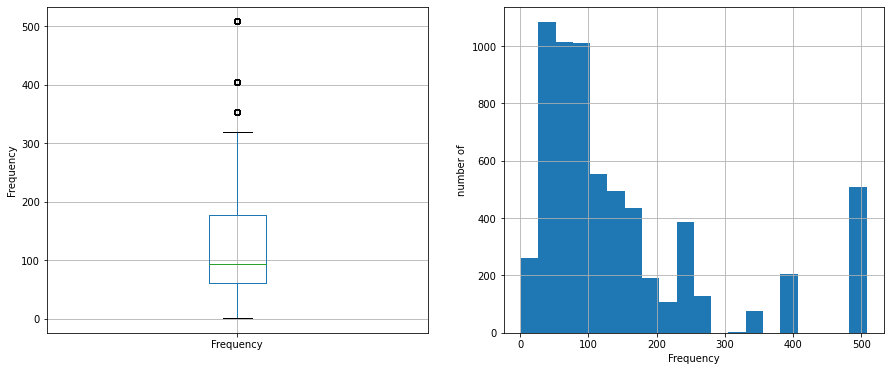

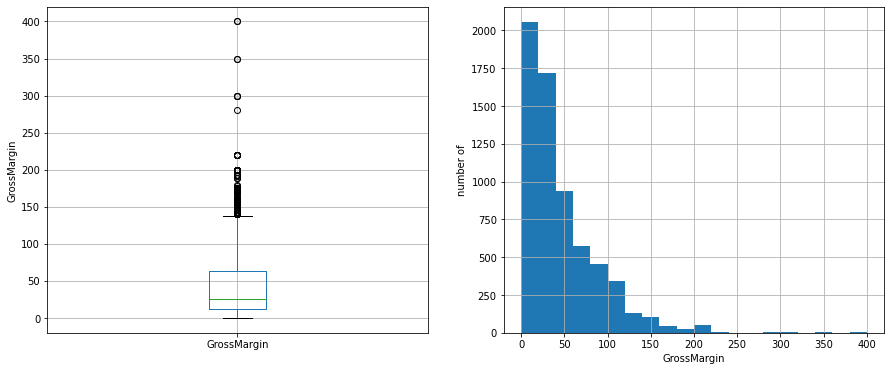

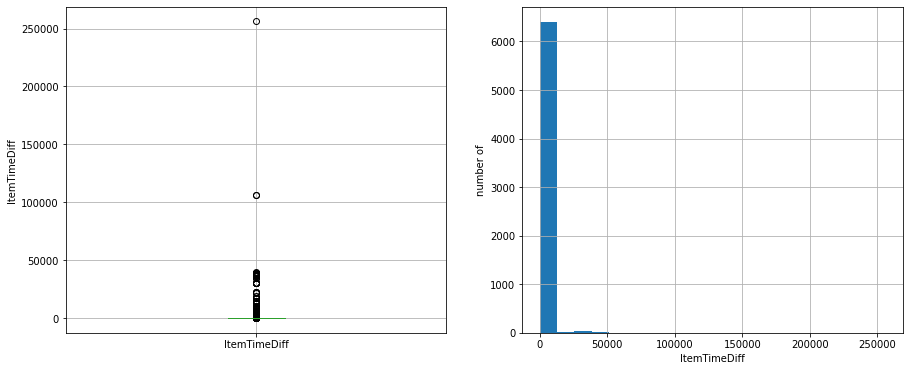

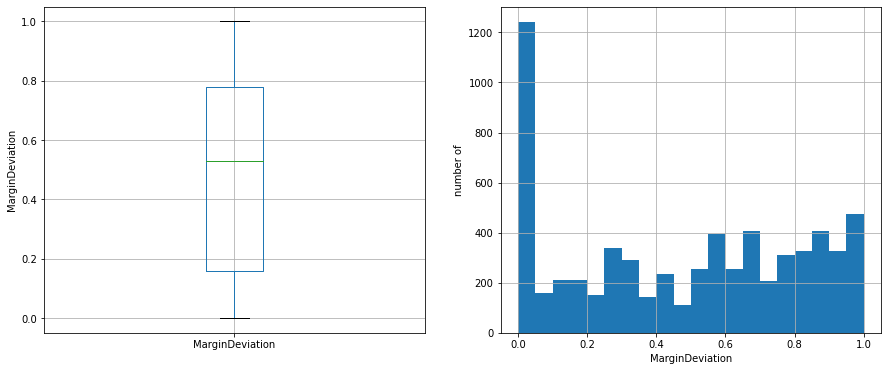

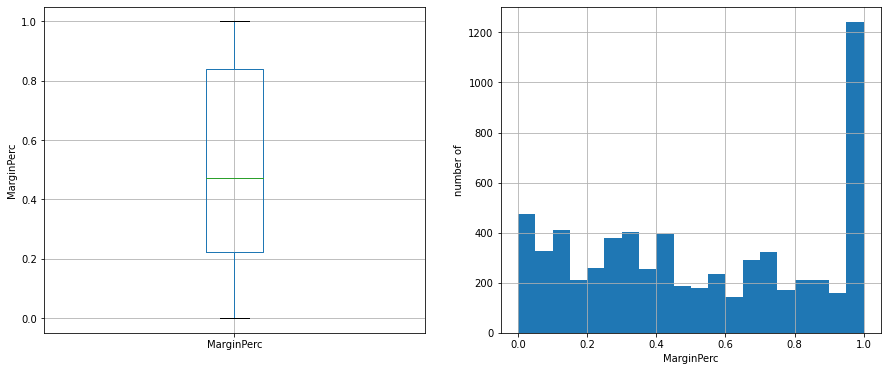

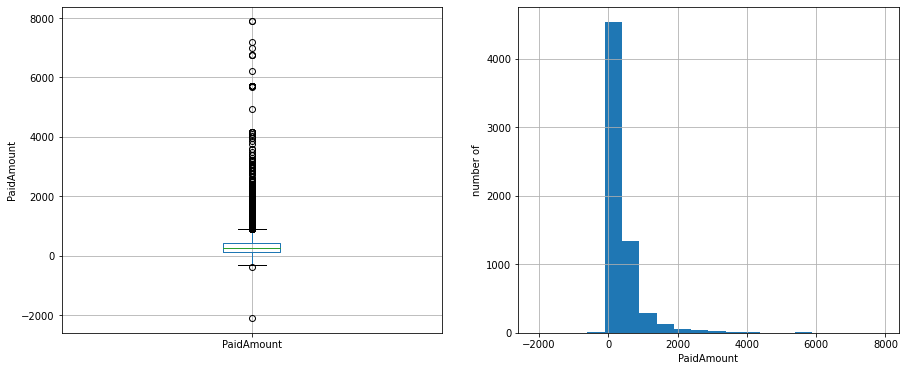

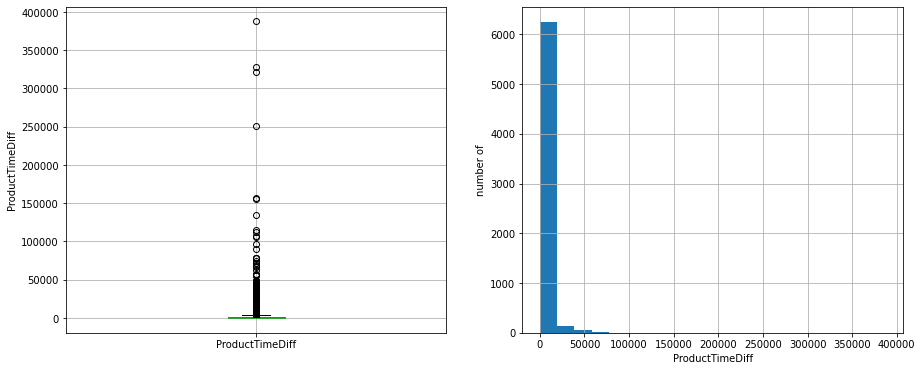

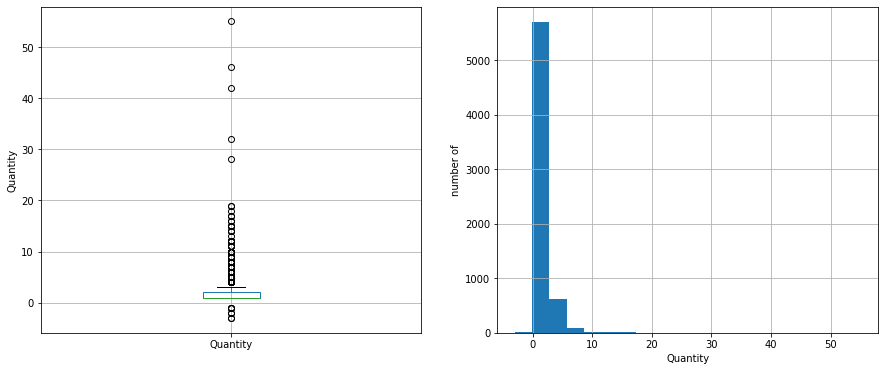

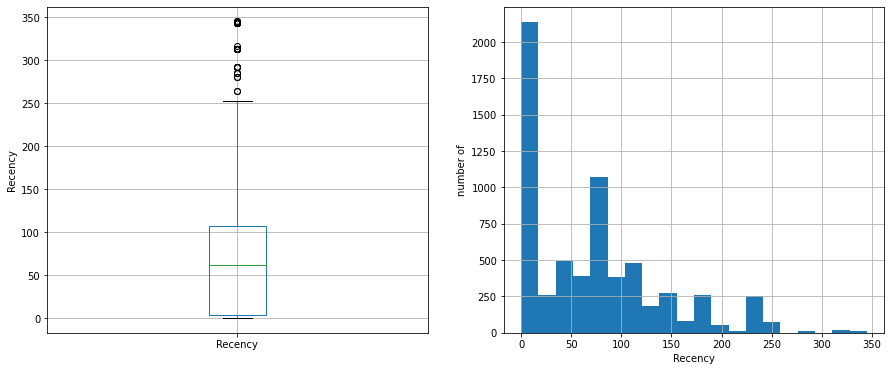

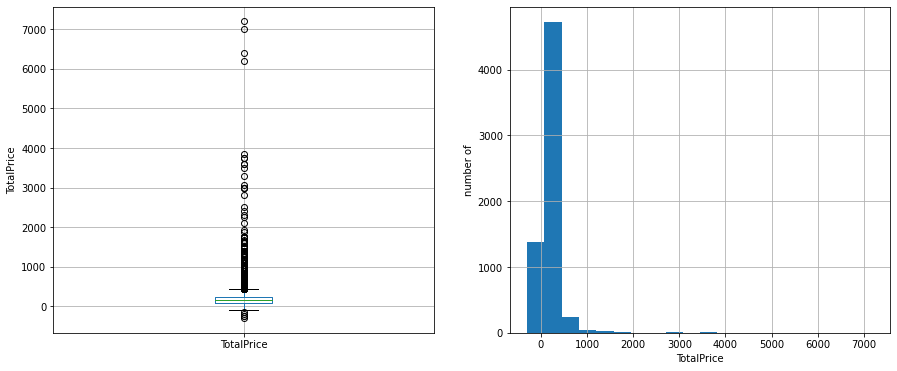

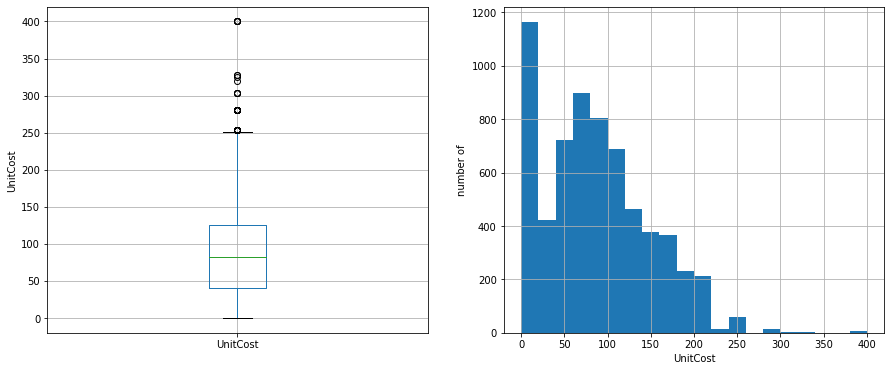

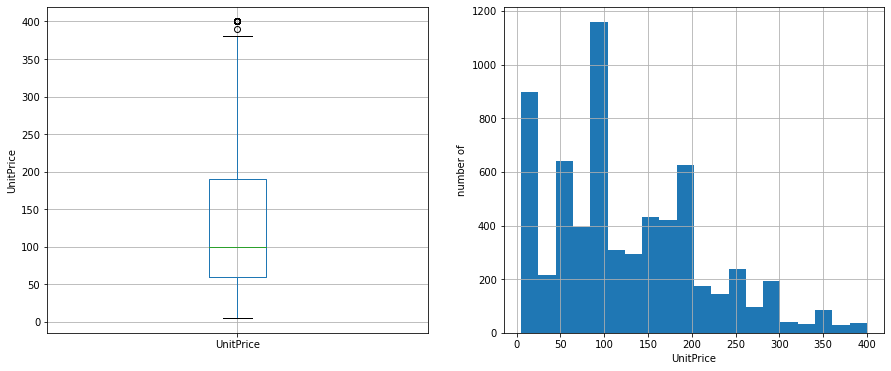

In [37]:
for var in numerical:
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    fig = df_tmp.boxplot(column=var)
    fig.set_title('')
    fig.set_ylabel(var)

    plt.subplot(1, 2, 2)
    fig = df_tmp[var].hist(bins=20)
    fig.set_ylabel('number of')
    fig.set_xlabel(var)

    plt.show()

# Feature selection

In [1]:
variances = X.var()
variances.sort_values(ascending=False, inplace=True)
variances.head(10)

NameError: name 'X' is not defined

In [39]:
corrs = abs(df_tmp.corr()['UnitPrice'])
corrs.sort_values(ascending=False, inplace=True)
corrs.head(10)

In [40]:
abs(df_tmp.corr()["UnitPrice"][abs(df_tmp.corr()["UnitPrice"])>0.5].drop('UnitPrice')).index.tolist()

['Frequency', 'GrossMargin', 'UnitCost']

In [41]:
cv = KFold(n_splits=10, random_state=0, shuffle=False)

pca = decomposition.PCA()

elasticnet = linear_model.ElasticNet()

model = Pipeline(steps=[('scaler', MinMaxScaler()),
                        ('pca', pca),
                        ('elasticnet', elasticnet)])

vals = [0.1,0.2,0.3,0.4,0.5,0.6]
for val in vals:
    features = abs(df_tmp.corr()["UnitPrice"][abs(df_tmp.corr()["UnitPrice"])>val].drop('UnitPrice')).index.tolist()

    X = df_tmp.drop(columns='UnitPrice')
    y = df_tmp.UnitPrice
    X=X[features]

    print(features)

    y_pred = cross_val_predict(model, X, y, cv=cv)
    print("RMSE: " + str(round(sqrt(mean_squared_error(y,y_pred)),2)))
    print("R_squared: " + str(round(r2_score(y,y_pred),2)))

/Users/erickamau/PycharmProjects/ADS/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



['Frequency', 'GrossMargin', 'PaidAmount', 'TotalPrice', 'UnitCost', 'product_Bedsheet 10', 'product_Bedsheets 7', 'product_Chiffon Tops Long Sleeve', 'product_Children Clothes W05', 'product_Denim Jacket 7', 'product_Denim Shirts', 'product_Denim dress 2', 'product_Denim jackets 3', 'product_Drawers', 'product_Duvet cover', 'product_Fagia', 'product_Fur coats', 'product_Hoodies 4', 'product_Jambo shoes', 'product_Ladies sweaters', 'product_Men jeans 3', 'product_Men jeans 4', 'product_Sweat Suits', 'product_Sweat pants 2', 'product_Swim suits', 'product_paper bags', 'product_skinny jeans', 'product_socks']
RMSE: 79.12
R_squared: 0.17
['Frequency', 'GrossMargin', 'PaidAmount', 'TotalPrice', 'UnitCost', 'product_Fagia', 'product_paper bags']
RMSE: 79.21
R_squared: 0.17
['Frequency', 'GrossMargin', 'TotalPrice', 'UnitCost', 'product_Fagia']
RMSE: 79.55
R_squared: 0.16
['Frequency', 'GrossMargin', 'TotalPrice', 'UnitCost']
RMSE: 80.26
R_squared: 0.15
['Frequency', 'GrossMargin', 'UnitCost

In [43]:
X = pd.DataFrame(df_tmp[['Frequency', 'GrossMargin', 'MarginDeviation', 'MarginPerc', 'Recency',
                         'TotalPrice', 'UnitCost']])
y_pred = cross_val_predict(model, X, y, cv=cv)
print("RMSE: " + str(round(sqrt(mean_squared_error(y,y_pred)),2)))
print("R_squared: " + str(round(r2_score(y,y_pred),2)))

RMSE: 80.39
R_squared: 0.15


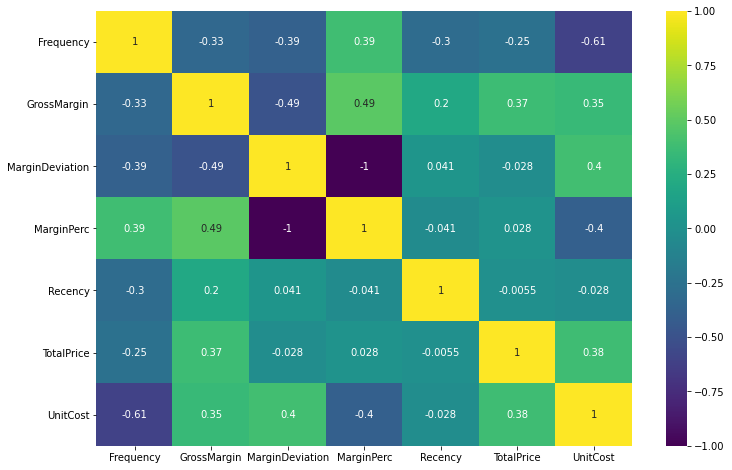

In [44]:
plt.figure(figsize=(12, 8))
sns.heatmap(X.corr(), annot=True, cmap='viridis')
plt.show()

# Train / Test split

In [45]:
np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5167, 7), (1292, 7), (5167,), (1292,))

In [46]:
'''save train and test datasets to csv'''

X_train.to_csv('train.csv')
X_test.to_csv('test.csv')

 ## Trying out different Regression models

Trying to decide which regression algorithm to go with for our problem
Options:
- Random forest
- Decision tree

In [47]:
%%time

# Instantiate model
rfr = RandomForestRegressor(n_jobs=-1,
                              random_state=42)
# Fit the model
rfr.fit(X_train, y_train)

# Score the model on the training set
print("model score: " + str(rfr.score(X_train, y_train)))
print("cross validation score: " + str(cross_val_score(rfr, X_train, y_train, cv=5)))

model score: 0.9998839843765884
cross validation score: [0.99900244 0.99891439 0.99952806 0.99810921 0.99925491]
CPU times: user 1.72 s, sys: 339 ms, total: 2.06 s
Wall time: 7.78 s


In [48]:
%%time

dtr = DecisionTreeRegressor(criterion="mse",
                              splitter="best",
                              random_state=42)

# Fit the model
dtr.fit(X_train, y_train)

# Score the model on the training set
print("model score: " + str(dtr.score(X_train, y_train)))
print("cross validation score: " + str(cross_val_score(dtr, X_train, y_train, cv=5)))

model score: 1.0
cross validation score: [0.99553361 0.99902298 0.99873922 0.99804183 0.9986373 ]
CPU times: user 72.7 ms, sys: 4.1 ms, total: 76.8 ms
Wall time: 84.8 ms


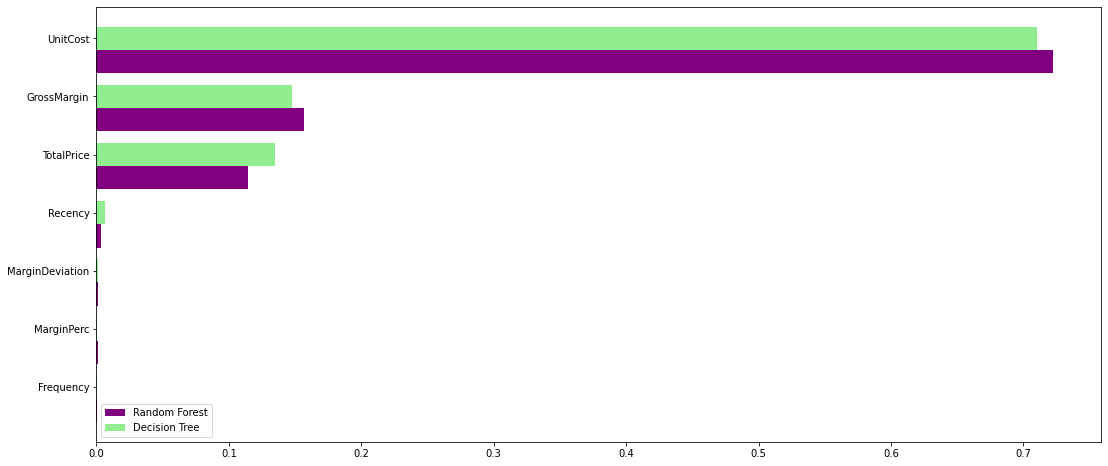

In [49]:
'''visualizing the feature importance as per both models'''

ml_feature_importance = pd.DataFrame({'rfr': rfr.feature_importances_,
                                      'dtr': dtr.feature_importances_},
                                     index=X.columns)
ml_feature_importance.sort_values(by='rfr', ascending=True, inplace=True)

index = np.arange(len(ml_feature_importance))
fig, ax = plt.subplots(figsize=(18,8))
rfr_feature = ax.barh(index, ml_feature_importance['rfr'], 0.4,color='purple', label='Random Forest')
dtr_feature = ax.barh(index+0.4, ml_feature_importance['dtr'], 0.4, color='lightgreen', label='Decision Tree')
ax.set(yticks=index+0.4, yticklabels=ml_feature_importance.index)

ax.legend()
plt.show()

Opting to go for a RandomForestRegressor to predict unit price for items.

Building an evaluation function

In [50]:
# Create evaluation function (the competition uses RMSLE)

def rmsle(y_test, y_preds):
    """
    Calculates root mean squared log error between predictions and
    true labels.
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate model on a few different levels
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_test)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_test, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_test, val_preds),
              "Training R^2": r2_score(y_train, train_preds),
              "Valid R^2": r2_score(y_test, val_preds)}
    return scores

Testing our model on a subset (to tune the hyperparameters)

In [51]:
# Change max_samples value
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42,
                              min_samples_leaf=3000)

In [52]:
%%time
model.fit(X_train, y_train)


CPU times: user 170 ms, sys: 32.5 ms, total: 203 ms
Wall time: 198 ms


RandomForestRegressor(min_samples_leaf=3000, n_jobs=-1, random_state=42)

In [53]:
show_scores(model)

{'Training MAE': 71.28553906921256,
 'Valid MAE': 71.66861318794372,
 'Training RMSLE': 0.9242253209865297,
 'Valid RMSLE': 0.9431366906325973,
 'Training R^2': -1.6676547767158212e-06,
 'Valid R^2': -5.826785680884683e-05}

In [54]:
'''differentiating RandomForestRegressor hyperparameters'''
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"]}

'''instantiating the randomized search model'''
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                              random_state=42),
                              param_distributions=rf_grid,
                              n_iter=2,
                              cv=cv,
                              verbose=True)

'''fitting the randomized search model'''
rs_model.fit(X_train, y_train)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    4.1s finished


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=False),
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=2,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [55]:
# find best params
rs_model.best_params_

{'n_estimators': 60,
 'min_samples_split': 12,
 'min_samples_leaf': 1,
 'max_features': 1,
 'max_depth': None}

In [56]:
# evaluate the random search model
show_scores(rs_model)

{'Training MAE': 1.7017743411376434,
 'Valid MAE': 2.1760430589890642,
 'Training RMSLE': 0.036520074508884524,
 'Valid RMSLE': 0.04657962988689856,
 'Training R^2': 0.9968910817169842,
 'Valid R^2': 0.9947421777468292}

In [57]:
%%time
'''model with most ideal parameters'''

ideal_model = RandomForestRegressor(n_estimators= 60,
                                    min_samples_split= 12,
                                    min_samples_leaf= 1,
                                    max_features= 'sqrt',
                                    max_depth= None,
                                    n_jobs=-1,
                                    random_state=42)

'''fitting the model'''
ideal_model.fit(X_train, y_train)

CPU times: user 277 ms, sys: 22.4 ms, total: 299 ms
Wall time: 172 ms


RandomForestRegressor(max_features='sqrt', min_samples_split=12,
                      n_estimators=60, n_jobs=-1, random_state=42)

In [58]:
# evaluate ideal model
show_scores(ideal_model)

{'Training MAE': 1.0021472767704251,
 'Valid MAE': 1.2849925334328214,
 'Training RMSLE': 0.024417907320111173,
 'Valid RMSLE': 0.03940156946102974,
 'Training R^2': 0.998281617040395,
 'Valid R^2': 0.9977225593506593}

In [59]:
'''running model on test data'''
test_pred = ideal_model.predict(X_test)

In [60]:
ideal_model.feature_importances_

array([0.09768014, 0.16829046, 0.03960311, 0.0285437 , 0.04065043,
       0.19636619, 0.42886596])

In [61]:
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))

    # plot dataframe
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature Importance")
    ax.invert_yaxis()

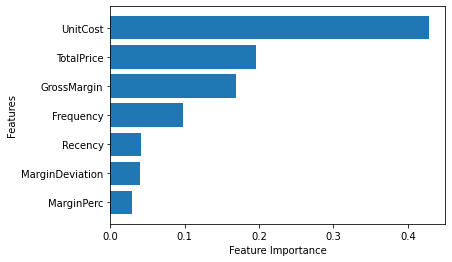

In [62]:
plot_features(X_train.columns, ideal_model.feature_importances_)

In [63]:
'''Let's check correlation of values in the train set'''

abs(df_tmp.corr()['UnitPrice'])

Day                                 0.006391
DayOfWeek                           0.004978
Frequency                           0.599025
GrossMargin                         0.737017
Hour                                0.028251
                                      ...   
product_school shoes n.5,6,7 950         NaN
product_skinny jeans                0.114725
product_socks                       0.137119
product_vans                             NaN
product_velvet wear                 0.005023
Name: UnitPrice, Length: 259, dtype: float64

In [58]:
# cv = KFold(n_splits=10, random_state=42)
#
# sfs = SFS(ideal_model,
#           k_features=5,
#           forward=True,
#           scoring="r2",
#           cv=cv)
#
# sfs.fit(X_train, y_train)
# sfs.subsets_

/Users/erickamau/PycharmProjects/ADS/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



{1: {'feature_idx': (1,),
  'cv_scores': array([0.72378305, 0.72578153, 0.71865166, 0.71250987, 0.67743754,
         0.70239567, 0.70484108, 0.68915949, 0.7131233 , 0.70520858]),
  'avg_score': 0.7072891761526292,
  'feature_names': ('GrossMargin',)},
 2: {'feature_idx': (1, 9),
  'cv_scores': array([0.99806335, 0.99765579, 0.99856407, 0.99807753, 0.99557799,
         0.9945496 , 0.99779157, 0.99570403, 0.99744779, 0.99780817]),
  'avg_score': 0.9971239888979259,
  'feature_names': ('GrossMargin', 'UnitCost')},
 3: {'feature_idx': (1, 4, 9),
  'cv_scores': array([0.99747673, 0.9991582 , 0.99931362, 0.99817839, 0.99717041,
         0.99472594, 0.9992021 , 0.99670513, 0.99882847, 0.99806464]),
  'avg_score': 0.9978823650436661,
  'feature_names': ('GrossMargin', 'MarginDeviation', 'UnitCost')},
 4: {'feature_idx': (1, 4, 9, 12),
  'cv_scores': array([0.99715898, 0.99917634, 0.99892257, 0.99811569, 0.9969722 ,
         0.99489693, 0.99917179, 0.99668488, 0.99883496, 0.99766558]),
  'avg_s

In [65]:
# X_new = df_tmp.drop(columns="UnitPrice")[['Frequency', 'GrossMargin', 'LastPurDay', 'LastPurMonth', 'MarginDeviation',
#                         'MarginPerc', 'PaidAmount', 'Recency', 'TotalPrice', 'UnitCost', 'WeekDayOfLastPur',
#                         'WeekOfLastPur', 'DeviationType_Negative', 'DeviationType_Positive', 'ProfitLoss_Loss',
#                         'ProfitLoss_Profit', 'ProductTimeDiff', 'ItemTimeDiff']]
# y_new = df_tmp["UnitPrice"]

y_pred = cross_val_predict(ideal_model, X, y, cv=cv)
print("RMSE: " + str(round(sqrt(mean_squared_error(y, y_pred)), 3)))
print("R_squared: " +str(round(r2_score(y,y_pred), 3)))

RMSE: 6.586
R_squared: 0.994


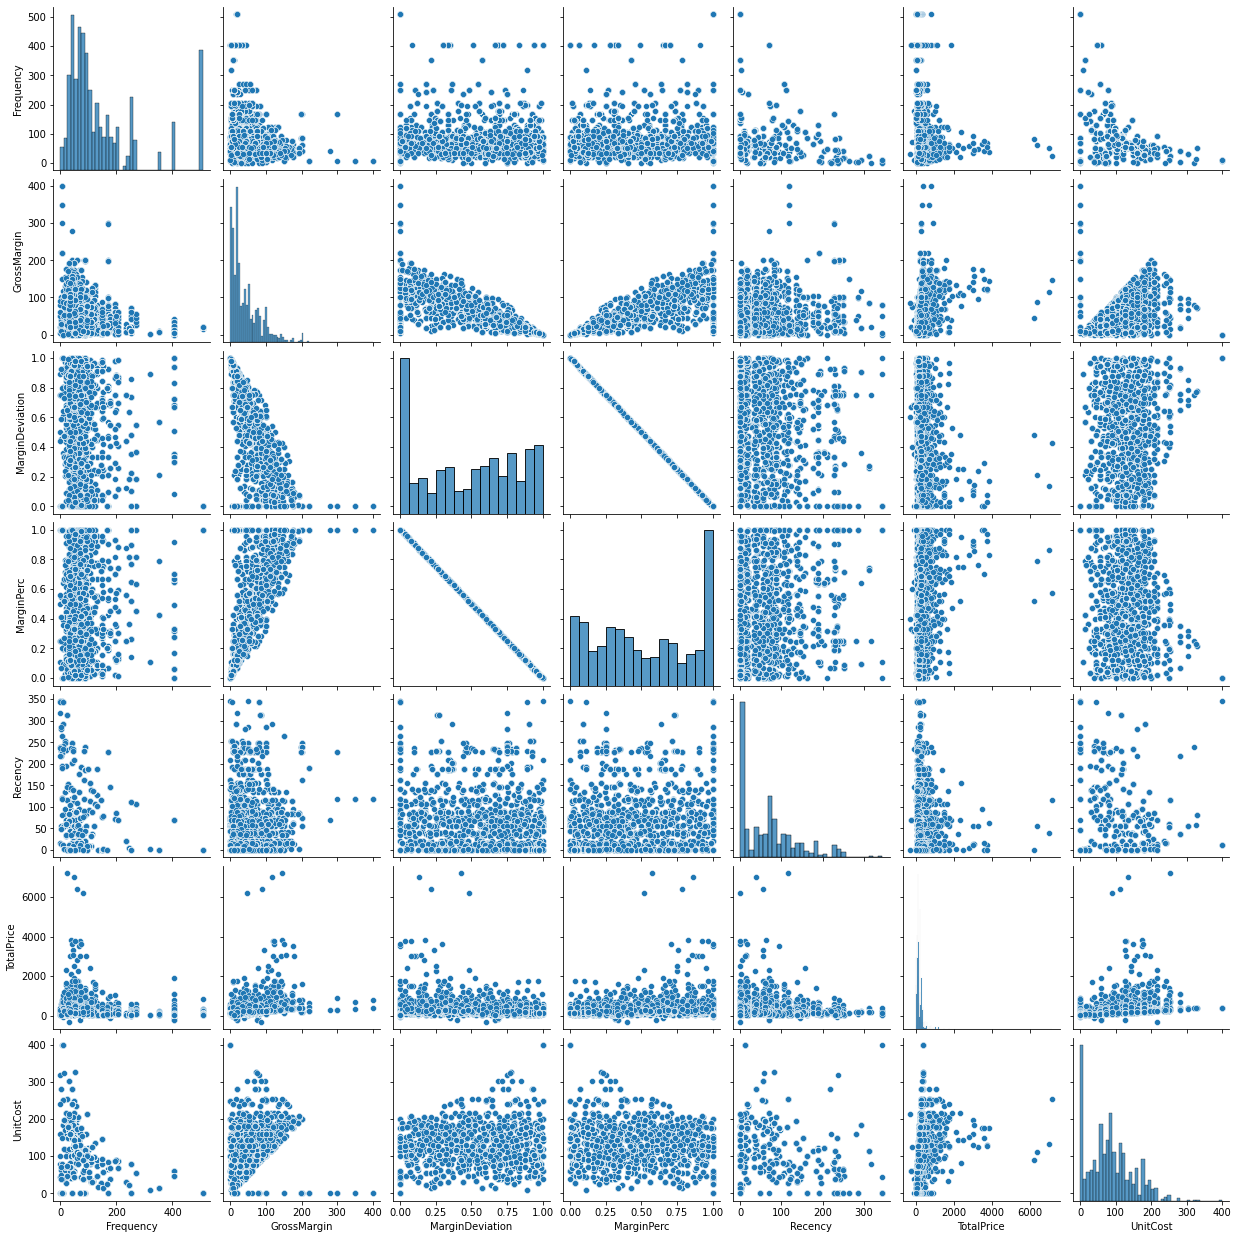

In [66]:
sns.pairplot(X)


In [68]:
rnd_test = ideal_model.fit(X_test, y_test)

In [69]:
show_scores(rnd_test)

{'Training MAE': 3.870518413646029,
 'Valid MAE': 2.6669562330289422,
 'Training RMSLE': 0.07493538853267527,
 'Valid RMSLE': 0.05320331119365866,
 'Training R^2': 0.9877907265227903,
 'Valid R^2': 0.9944271732765907}